In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler


from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

Dataset

In [23]:
data = pd.read_csv("car.data.csv")

In [24]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,quality
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [25]:
# Encode categorical variables using Label Encoding
label_encoder = LabelEncoder()
categorical_cols = ['buying', 'maint', 'lug_boot', 'safety']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [26]:
data.replace("5more", 5, inplace=True)
data.replace("more", 5, inplace=True)

In [27]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,quality
0,3,3,2,2,2,1,unacc
1,3,3,2,2,2,2,unacc
2,3,3,2,2,2,0,unacc
3,3,3,2,2,1,1,unacc
4,3,3,2,2,1,2,unacc


In [28]:
X = data.drop("quality", axis=1)
y = data["quality"]

label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
xgboost_model = XGBClassifier(objective='multi:softmax', num_class=len(label_mapping))
xgboost_model.fit(X_train, y_train, verbose = 5)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [32]:
catboost_model = CatBoostClassifier(iterations = 150 , depth = 5, learning_rate = 0.3 , loss_function='MultiClass')
catboost_model.fit(X_train, y_train, verbose = 15)

0:	learn: 1.0686535	total: 3.8ms	remaining: 566ms
15:	learn: 0.2327509	total: 49.8ms	remaining: 417ms
30:	learn: 0.1250383	total: 96.2ms	remaining: 369ms
45:	learn: 0.0835822	total: 148ms	remaining: 334ms
60:	learn: 0.0603047	total: 202ms	remaining: 295ms
75:	learn: 0.0472289	total: 248ms	remaining: 241ms
90:	learn: 0.0393155	total: 300ms	remaining: 195ms
105:	learn: 0.0337713	total: 347ms	remaining: 144ms
120:	learn: 0.0291882	total: 393ms	remaining: 94.2ms
135:	learn: 0.0261485	total: 437ms	remaining: 45ms
149:	learn: 0.0235396	total: 476ms	remaining: 0us


In [33]:
y_pred1 = xgboost_model.predict(X_test)

In [34]:
y_pred2 = catboost_model.predict(X_test)

In [35]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy (XGBoost): {accuracy1 * 100:.2f}%")

Accuracy (XGBoost): 98.07%


In [36]:
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy (CatBoost): {accuracy1 * 100:.2f}%")

Accuracy (CatBoost): 98.07%


In [37]:
conf_matrix1 = confusion_matrix(y_test, y_pred1)

In [38]:
conf_matrix2 = confusion_matrix(y_test, y_pred2)

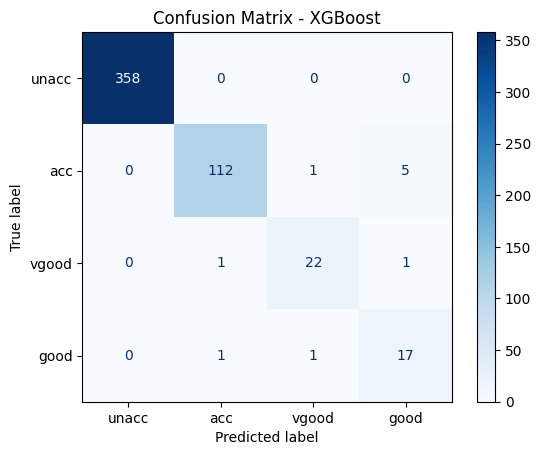

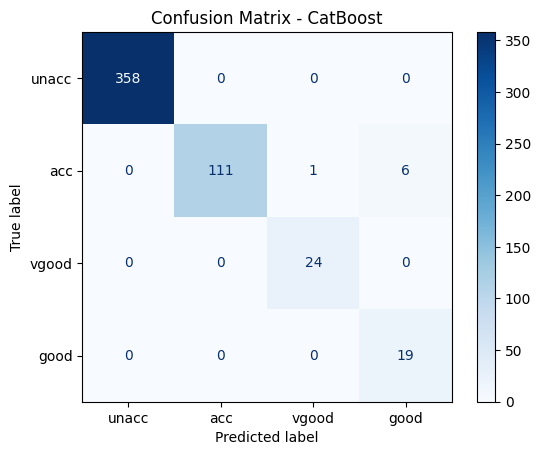

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix1, display_labels=label_mapping.keys())
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix - XGBoost')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels=label_mapping.keys())
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix - CatBoost')
plt.show()

In [40]:
y_test_bin1 = label_binarize(y_test, classes=list(label_mapping.values()))
y_pred_prob1 = xgboost_model.predict_proba(X_test)

y_test_bin2 = label_binarize(y_test, classes=list(label_mapping.values()))
y_pred_prob2 = catboost_model.predict_proba(X_test)

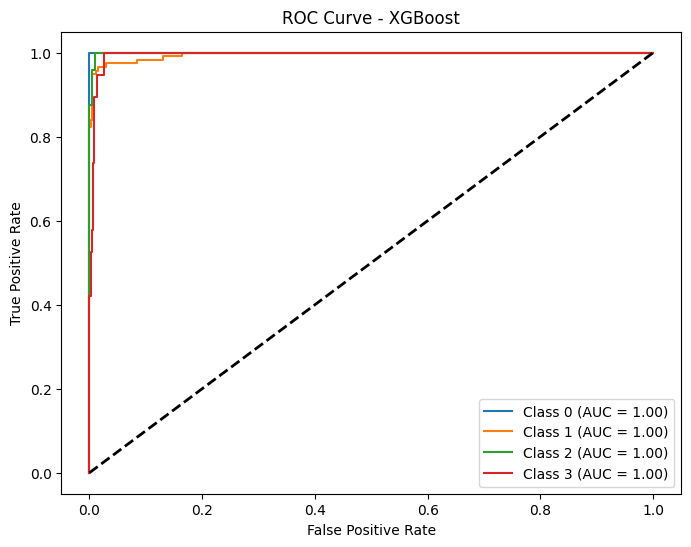

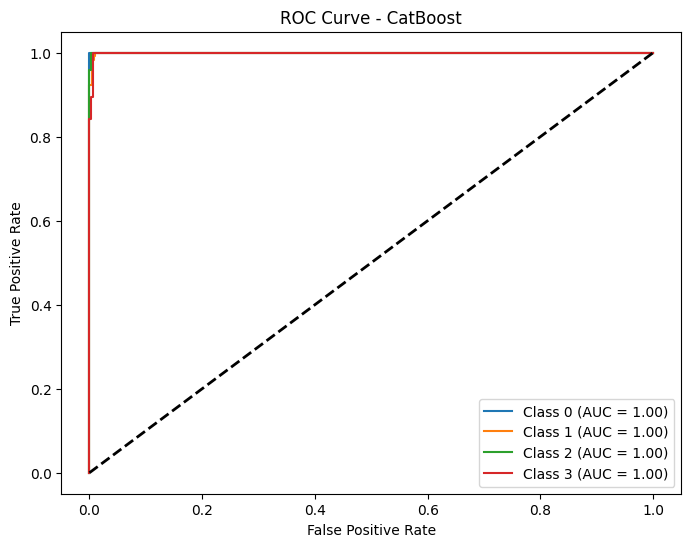

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(xgboost_model.classes_.shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin1[:, i], y_pred_prob1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))

for i in range(xgboost_model.classes_.shape[0]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(catboost_model.classes_.shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin2[:, i], y_pred_prob2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))

for i in range(catboost_model.classes_.shape[0]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()

In [42]:
classification_rep_xgboost = classification_report(y_test, y_pred1, digits=4)
classification_rep_catboost = classification_report(y_test, y_pred2, digits=4)

print("Classification Report (XGBoost):")
print(classification_rep_xgboost)
print()
print("Classification Report (CatBoost):")
print(classification_rep_catboost)

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       358
           1     0.9825    0.9492    0.9655       118
           2     0.9167    0.9167    0.9167        24
           3     0.7391    0.8947    0.8095        19

    accuracy                         0.9807       519
   macro avg     0.9096    0.9401    0.9229       519
weighted avg     0.9826    0.9807    0.9813       519


Classification Report (CatBoost):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       358
           1     1.0000    0.9407    0.9694       118
           2     0.9600    1.0000    0.9796        24
           3     0.7600    1.0000    0.8636        19

    accuracy                         0.9865       519
   macro avg     0.9300    0.9852    0.9532       519
weighted avg     0.9894    0.9865    0.9871       519

